# Use group_day TCA as "canonical" facors for matching cell_factors

In [ ]:
"""Functions for plotting tca decomp."""
import os
import flow
import pool
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
import tensortools as tt
import seaborn as sns
import pandas as pd
from copy import deepcopy
from cascade import df
from cascade import tca
# from random import shuffle
from cascade import paths

In [ ]:
mouse='OA27'
trace_type='zscore_day'
method='ncp_bcd'
cs=''
warp=False
rank_num = 10

group_by='high_dprime_learning'
verbose=False

In [ ]:
word='supply'

# group day loader
pars = {'trace_type': trace_type, 'cs': cs, 'warp': warp}
group_pars = {'group_by': group_by}

# load dir
load_dir = paths.tca_path(
    mouse, 'group', pars=pars, word=word, group_pars=group_pars)
template_tensor_path = os.path.join(
    load_dir, str(mouse) + '_' + str(group_by)
    + '_group_decomp_' + str(trace_type) + '.npy')
template_meta_path = os.path.join(
    load_dir, str(mouse) + '_' + str(group_by)
    + '_df_group_meta.pkl')
template_ids_path = os.path.join(
    load_dir, str(mouse) + '_' + str(group_by)
    + '_group_ids_' + str(trace_type) + '.npy')

# load your data
template_ensemble = np.load(template_tensor_path)
template_ensemble = template_ensemble.item()
ids = np.load(template_ids_path)
meta = pd.read_pickle(template_meta_path)

# get trial metadate
template_orientation = meta['orientation']
template_trial_num = np.arange(0, len(template_orientation))
template_condition = meta['condition']
template_trialerror = meta['trialerror']
template_hunger = deepcopy(meta['hunger'])
template_speed = meta['speed']
template_dates = meta.reset_index()['date']
template_learning_state = meta['learning_state']

# merge hunger and tag info for plotting hunger
template_tags = meta['tag']
template_hunger[template_tags == 'disengaged'] = 'disengaged'

# calculate change indices for days and reversal/learning
udays = {d: c for c, d in enumerate(np.unique(template_dates))}
ndays = np.diff([udays[i] for i in template_dates])
day_x = np.where(ndays)[0] + 0.5
ustate = {d: c for c, d in enumerate(np.unique(template_learning_state))}
nstate = np.diff([ustate[i] for i in template_learning_state])
lstate_x = np.where(nstate)[0] + 0.5

# sort neuron factors by component they belong to most
template_sort_ensemble, template_my_sorts = tca._sortfactors(template_ensemble[method])

# put ids in correct order (k is 1 indexedexed)
template_cell_ids = {}  # keys are rank
for k in template_sort_ensemble.results.keys():
    template_cell_ids[k] = ids[template_my_sorts[k-1]]
    
# get template factors of interest
template_factors = template_sort_ensemble.results[rank_num][0]
template_cell_ids = template_cell_ids[rank_num]

In [149]:
# single day loader
rank_num = 10
word = 'convinced'

# pars for loading tca data
pars = {'trace_type': trace_type, 'cs': cs, 'warp': warp}

# create datesorter
days = flow.DateSorter.frommeta(mice=[mouse], tags=None)

conds_by_day = []
oris_by_day = []
trialerr_by_day = []
neuron_ids_by_day = []
neuron_clusters_by_day = []
factors_by_day = []
ndate = []

# loop through days in FORWARD order
for day1 in days:

    # load dir
    load_dir = paths.tca_path(mouse, 'single',
                              pars=pars, word=word)
    tensor_path = os.path.join(load_dir, str(day1.mouse)
                               + '_' + str(day1.date)
                               + '_single_decomp_'
                               + str(trace_type) + '.npy')
    input_tensor_path = os.path.join(load_dir, str(day1.mouse)
                                     + '_' + str(day1.date)
                                     + '_single_tensor_'
                                     + str(trace_type) + '.npy')
    input_ids_path = os.path.join(load_dir, str(day1.mouse)
                                  + '_' + str(day1.date)
                                  + '_single_ids_'
                                  + str(trace_type) + '.npy')
    meta_path = os.path.join(load_dir, str(day1.mouse)
                             + '_' + str(day1.date)
                             + '_df_single_meta.pkl')

    # load your metadata, skip post reversal days
    meta = pd.read_pickle(meta_path)
    condition = meta['condition']
    orientation = meta['orientation']
    trialerror = meta['trialerror']
    if 'reversal5' in meta['learning_state'].unique() \
    or 'reversal2' in meta['learning_state'].unique():
        continue

    # skip days that do not have minus, AND neutral
    if 'minus' not in meta['condition'].unique() \
    or 'neutral' not in meta['condition'].unique() \
    or 'plus' not in meta['condition'].unique():
        continue
    
    # print
    ndate.append(day1.date)
    print(day1.date)
    
    # load your data
    ensemble = np.load(tensor_path)
    ensemble = ensemble.item()
    ids = np.load(input_ids_path)
    
    # sort neuron factors by component they belong to most
    sort_ensemble, my_sorts = tca._sortfactors(ensemble[method])

    cell_ids = {}  # keys are rank
    cell_clusters = {}
    itr_num = 0  # use only best iteration of TCA, index 0
    for k in sort_ensemble.results.keys():
        # factors are already sorted, so these will define
        # clusters, no need to sort again
        factors = sort_ensemble.results[k][itr_num].factors[0]
        max_fac = np.argmax(factors, axis=1)
        cell_clusters[k] = max_fac
        cell_ids[k] = ids[my_sorts[k-1]]

    neuron_ids_by_day.append(cell_ids[rank_num])
    neuron_clusters_by_day.append(cell_clusters[rank_num])
    factors_by_day.append(sort_ensemble.results[rank_num][0])
    conds_by_day.append(condition)
    oris_by_day.append(orientation)
    trialerr_by_day.append(trialerror)

170116
170118
170119
170125
170204
170206
170207
170208
170209
170210
170211
170214
170215
170216
170217
170220
170223
170224
170303
170308
170318
170320
170321
170322
170323
170326
170328
170403
170404


In [157]:
# ------------------------------------------------------------

# create similarity matrices for comparison of all neuron
# factors weights between a pair of days
on_sim_mat_by_day = []
off_sim_mat_by_day = []
tuning_sim_mat_by_day = []
cells_compared = []
for i in range(len(factors_by_day)):

    # always compare in the time-forward direction
    ids1 = template_cell_ids
    ids2 = neuron_ids_by_day[i]
    ids1_bool = np.isin(ids1, ids2)
    ids2_bool = np.isin(ids2, ids1)

    # get sort order to match ids between days
    ids1_sort = np.argsort(ids1[ids1_bool])
    ids2_sort = np.argsort(ids2[ids2_bool])

    # get neuron factor weight matrices for ids matched
    # between days
    ids1_weights = template_factors.factors[0][ids1_bool, :]
    ids2_weights = factors_by_day[i].factors[0][ids2_bool, :]
    print(np.shape(ids1_weights))
    cells_compared.append(np.shape(ids1_weights)[0])
    # get temporal factor weight matrices
#     tempo1_weights = template_factors.factors[1][:, :]
#     tempo2_weights = factors_by_day[i].factors[1][:, :]

#     # get trial factor weight matrices
#     trial1_weights = template_factors.factors[2][:, :]
#     trial2_weights = factors_by_day[i].factors[2][:, :]
#     # get trial factor orientations
#     trial1_oris = template_orientation
#     trial2_oris = oris_by_day[i]

#     # get tuning of trials to 0, 135, 270
#     # (mean response per-factor per-ori) / sum(mean responses)
#     tuning1_weights = np.zeros((3, rank_num))
#     tuning2_weights = np.zeros((3, rank_num))
#     oris_to_check = [0, 135, 270]
#     for c, ori in enumerate(oris_to_check):
#         tuning1_weights[c, :] = np.nanmean(trial1_weights[trial1_oris == ori, :], axis=0)
#         tuning2_weights[c, :] = np.nanmean(trial2_weights[trial2_oris == ori, :], axis=0)
#     # normalize using summed mean response to all three
#     tuning1_total = np.nansum(tuning1_weights, axis=0)
#     tuning2_total = np.nansum(tuning2_weights, axis=0)
#     for c in range(len(oris_to_check)):
#         tuning1_weights[c, :] = np.divide(tuning1_weights[c, :], tuning1_total)
#         tuning2_weights[c, :] = np.divide(tuning2_weights[c, :], tuning2_total)
#     # make sure 0/0 = 0 rather than nan
#     tuning1_weights[np.isnan(tuning1_weights)] = 0
#     tuning2_weights[np.isnan(tuning2_weights)] = 0
#     # binarize tuning
#     tuning1_weights[tuning1_weights > .75] = 1
#     tuning2_weights[tuning2_weights > .75] = 1
#     tuning1_weights[tuning1_weights <= .75] = 0
#     tuning2_weights[tuning2_weights <= .75] = 0
    
    on_corr = np.corrcoef(ids1_weights[ids1_sort, :].T, y=ids2_weights[ids2_sort, :].T)
#     on_corr = deepcopy(on_corr[-rank_num:, 0:rank_num])
    on_corr[np.isnan(on_corr)] = 0
    on_sim_mat_by_day.append(deepcopy(on_corr[-rank_num:, 0:rank_num]))
#     on_sim_mat_by_day.append(on2_weights.T @ on1_weights)

(62, 10)
(66, 10)
(59, 10)
(28, 10)
(57, 10)
(45, 10)
(55, 10)
(77, 10)
(98, 10)
(120, 10)
(101, 10)
(104, 10)
(94, 10)
(135, 10)
(155, 10)
(142, 10)
(125, 10)
(137, 10)
(183, 10)
(191, 10)
(129, 10)
(113, 10)
(104, 10)
(129, 10)
(165, 10)
(90, 10)
(99, 10)
(125, 10)
(78, 10)


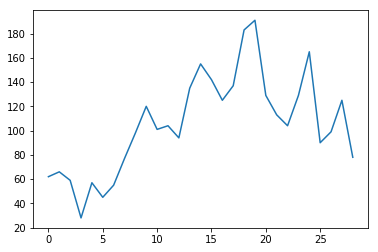

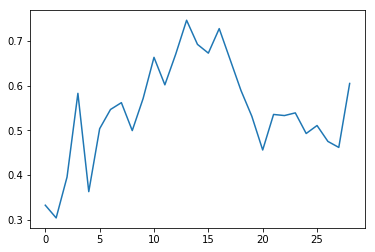

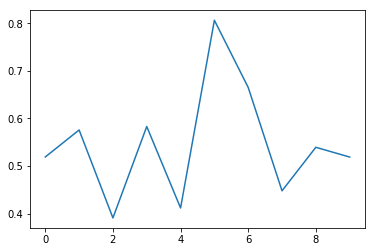

In [161]:
plt.figure()
plt.plot(cells_compared)
plt.figure()
plt.plot(np.mean(best_val, axis=1))
plt.figure()
plt.plot(np.mean(best_val, axis=0))

In [96]:
# colormap
day_num = len(ndate)
a = sns.color_palette("Greys", int(np.ceil(day_num*1.5)))[-day_num:]
b = sns.color_palette("Greens", day_num)
c = sns.color_palette("Reds", day_num)
d = sns.color_palette("Purples", day_num)
colors = {'naive': a, 'learning': b, 'reversal1': c, 'reversal2': d}

In [151]:
x = on_sim_mat_by_day[0]
x = np.argmax(x, axis=0)
# plt.figure()
best_arg = np.zeros((len(on_sim_mat_by_day), rank_num))
best_val = np.zeros((len(on_sim_mat_by_day), rank_num))
test_temp = []
for c, sim_mat in enumerate(on_sim_mat_by_day):
    y = np.argmax(sim_mat, axis=0)
    yv = np.max(sim_mat, axis=0)
    best_arg[c,:] = y
    best_val[c,:] = yv
    vec = np.arange(0,len(y), dtype='float')
    for k in vec:
        if np.isin(k, y):
            vec[int(k)] = k
        else:
            vec[int(k)] = np.nan
    print(y)
    best_match_to_template.append(y)
    test_temp.append(factors_by_day[c].factors[1][:, y[0]])
    
#     x = np.intersect1d(x, y)
#     print(x)
#     print(len(np.unique(np.argmax(sim_mat, axis=0))))

[0 9 9 4 8 3 5 1 6 8]
[7 4 4 8 4 1 4 0 3 2]
[8 1 1 3 3 7 1 4 3 6]
[9 6 4 7 7 0 4 3 0 2]
[7 0 8 8 2 1 1 9 2 3]
[4 0 2 2 5 6 1 7 8 4]
[6 4 4 4 0 3 9 8 2 8]
[1 0 2 7 3 9 8 4 6 4]
[7 0 2 2 9 1 4 6 0 6]
[9 1 5 6 0 3 2 4 8 9]
[7 3 0 0 8 1 6 2 4 5]
[1 6 5 5 3 8 4 7 2 1]
[0 8 4 4 2 7 1 5 6 5]
[0 1 6 7 8 3 5 8 4 9]
[2 9 7 7 8 6 0 5 1 2]
[5 4 1 8 6 0 9 2 4 5]
[1 3 4 5 2 8 9 0 7 6]
[8 4 0 3 9 5 0 6 7 1]
[1 5 0 7 8 6 9 4 6 4]
[9 7 8 5 4 6 0 3 7 9]
[1 7 9 0 1 2 3 1 7 1]
[2 7 4 4 5 1 9 5 8 2]
[5 0 7 9 7 2 1 8 0 5]
[6 1 5 9 7 2 3 0 8 5]
[2 3 6 0 5 1 8 4 7 4]
[1 9 4 7 4 0 4 2 3 5]
[9 8 8 1 5 9 3 2 7 2]
[3 6 4 0 4 9 1 1 5 7]
[6 2 7 4 1 0 5 5 3 7]


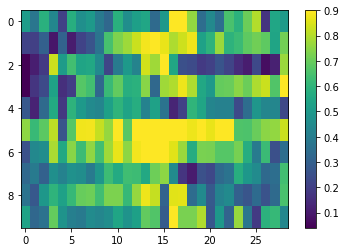

In [152]:
plt.figure()
plt.imshow(best_val.T, aspect='auto', vmax=0.9)
plt.colorbar()

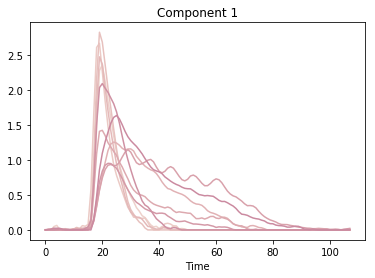

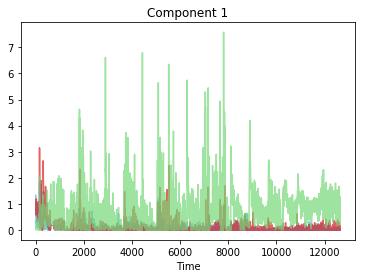

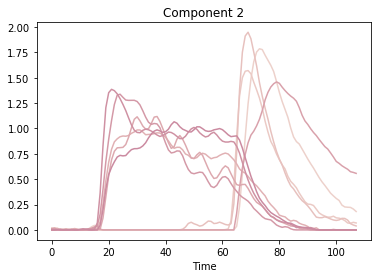

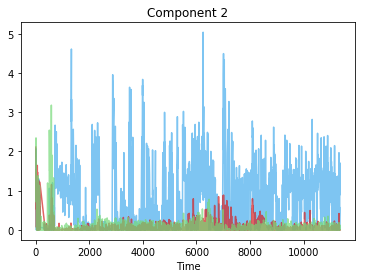

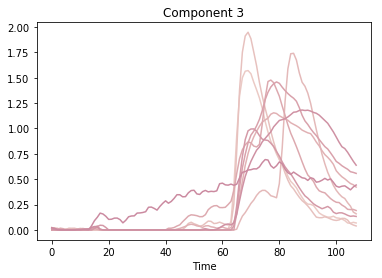

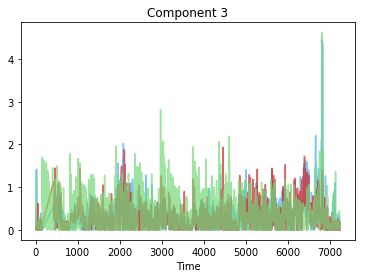

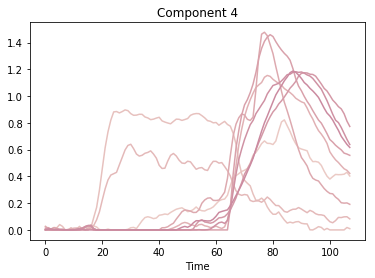

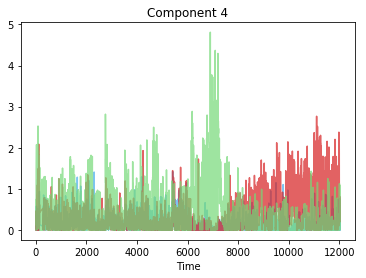

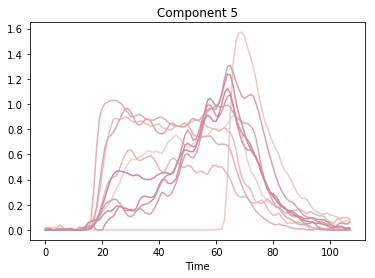

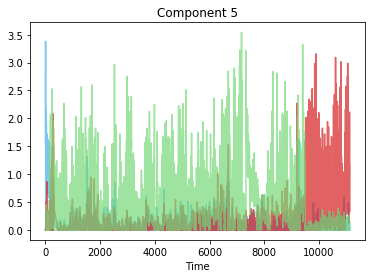

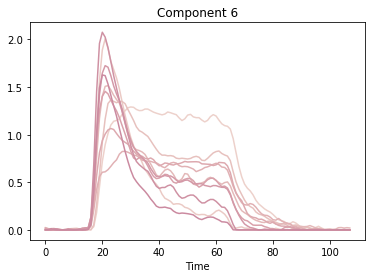

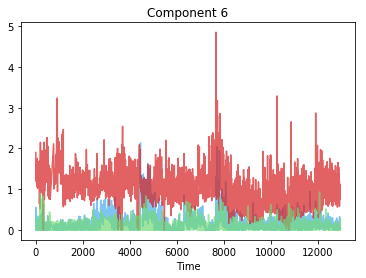

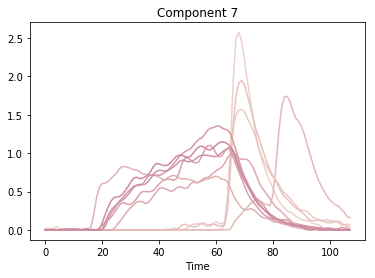

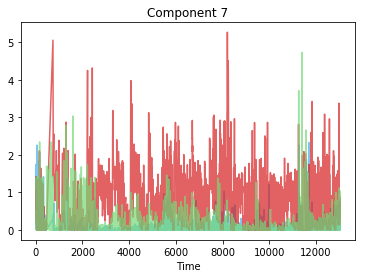

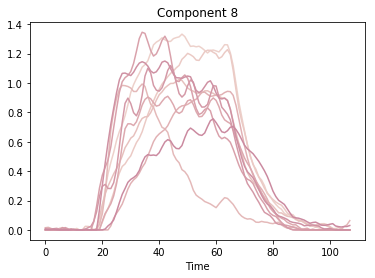

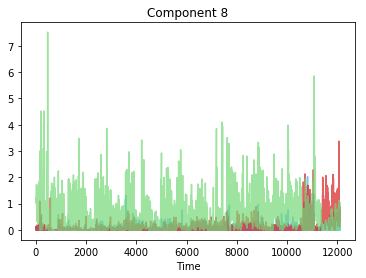

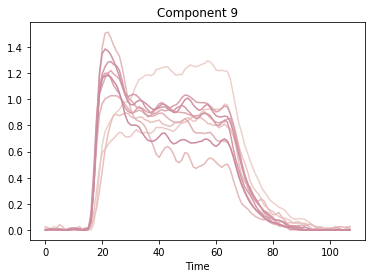

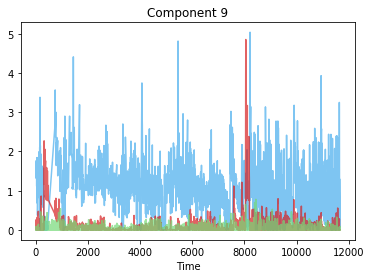

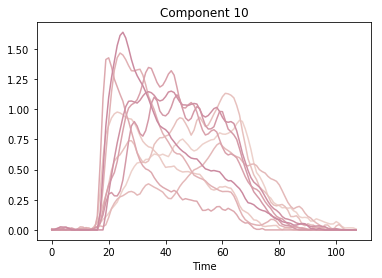

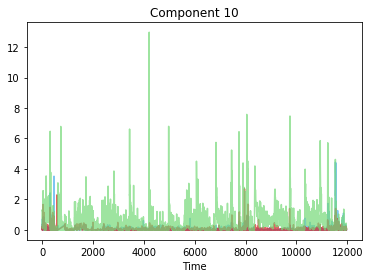

In [168]:
cmap = sns.color_palette(sns.cubehelix_palette(len(on_sim_mat_by_day)))
alpha = 0.7
color_vals = [[0.28, 0.68, 0.93, alpha], [0.84, 0.12, 0.13, alpha],[0.46, 0.85, 0.47, alpha]]

for k in range(rank_num):
    
    plt.figure()
    for i in range(len(on_sim_mat_by_day))[:10]:
        fac_ind = int(best_arg[i,k])
        fac_val = best_val[i,k]
        if fac_val < 0.10:
            continue
        plt.plot(factors_by_day[i].factors[1][:, fac_ind], color=cmap[i])
    plt.title('Component ' + str(k+1))
    plt.xlabel('Time')
    
    plt.figure()
    ori_vec = []
    trial_vec = []
    for i in range(len(on_sim_mat_by_day)):
        fac_ind = int(best_arg[i,k])
        fac_val = best_val[i,k]
        if fac_val < 0.30:
            continue
        ori_vec.extend(oris_by_day[i])
        trial_vec.extend(factors_by_day[i].factors[2][:, fac_ind])
    x = np.arange(0, len(ori_vec))
    trial_vec = np.array(trial_vec)
    for c, z in enumerate([0, 135, 270]):
        plt.plot(x[np.isin(ori_vec, z)], trial_vec[np.isin(ori_vec, z)], color=color_vals[c])
    plt.title('Component ' + str(k+1))
    plt.xlabel('Time')

In [147]:
int(np.where(np.isin(ori_vec, z))[0])

TypeError: only size-1 arrays can be converted to Python scalars

In [ ]:
for i in on_sim_mat_by_day:
    plt.figure()
    plt.imshow(i, vmin=0, vmax=1)
    plt.colorbar()

In [ ]:
print(ids1_sort)
print(ids2_sort)

In [ ]:
fig, axes = plt.subplots(rows, cols, figsize=(16, 4))
fig.suptitle('Cell #' + str(cell_idx) + ' - driven: '
             + title_tage, fontsize=16, y=1.05, weight='bold')
for col in range(cols):
    indexer = np.where(
        mean_df.reset_index()['orientation'] == oris[col])[0]
    traces = mean_df.iloc[indexer, :].values
    dates = mean_df.reset_index()['date'].iloc[indexer]
    state = mean_df.reset_index()['learning_state'].iloc[indexer]
    c_ind = color_ind[indexer]
    axes[col].set_title('Orientation = ' + str(oris[col]))
    if col == 0:
        axes[col].set_ylabel(r'$\Delta$' + 'F/F (z-score)')
    axes[col].set_xlabel('Time from stimulus onset (sec)')
    for l in range(np.shape(traces)[0]):
        axes[col].plot(
            times, traces[l, :], color=colors[state.iloc[l]][c_ind[l]],
            label=(str(dates.iloc[l]) + '-' + state.iloc[l]))
        if col == legend_ind:
            labels.append(str(dates.iloc[l]) + '-' + state.iloc[l])
axes[-1].legend(
    axes[legend_ind].lines, labels, loc='upper left',
    bbox_to_anchor=(1.02, 1.03), title='Days')